In [1]:
# Import libraries and set colors for plotting
import sys
import ete3
import os
import random
from os import walk
sys.path.insert(0,'../scripts/')
from classDeclarationsAndFunctions import RootedTree
from fileIO import ReadRootedTree
from MarkovModels import GenerateQForStationaryDistribution, Get11FreeRates
from math import floor, ceil
from config import projectPath
import matplotlib.pyplot as plt
import numpy as np
from math import log


method_colors_map = {}
method_colors_map['mstbackbone'] = ['darkblue']
method_colors_map['fasttree'] = ['black']
method_colors_map['raxmlng'] = ['fuchsia']
method_colors_map['iqtree'] = ['darkorange']


In [2]:
# Job scripts
data_path = projectPath + "data/"
tools_path_geniux = "/project/exaptation/Tools/"
num_trees_simulated = 0
for seq_len in [1000,2000,5000,10000]:
    iqtree_script = open("../batch_scripts/iqtree_scalability_"+str(seq_len)+".sh","w")
    mstbackbone_script = open("../batch_scripts/mstbackbone_scalability_"+str(seq_len)+".sh","w")
    fasttree_script = open("../batch_scripts/fastree_scalability_"+str(seq_len)+".sh","w")
    raxml_script = open("../batch_scripts/raxml_scalability_"+str(seq_len)+".sh","w")
    tree_id_num_leaves_scalability_file = open("../data/selected_grove_tree_ids_scalability","r")
    for line in tree_id_num_leaves_scalability_file:
        tree_id = line.strip().split(',')[0].strip()
        num_leaves = int(line.strip().split(',')[1].strip())
        num_trees_simulated += 1
        print("Writing batch commands for tree ", str(num_trees_simulated))
        mxqsub_prefix = ""
        exp_id = "treeId_"+tree_id+"_numLeaves_"+str(num_leaves)+"_seqLen_"+str(seq_len)
        exp_dir = data_path + "grove_exp/" + exp_id
        sequence_file_name = exp_dir + "/sequences_"+exp_id+".fas"
        ###############        IQ-TREE      ##################
        # mxqsub_prefix = "mxqsub -t 2d -m 10G -n -N iqtree_scale\t"
        # mxqsub_prefix += " --stderr=err_iqtree_scalability_"+exp_id
        # mxqsub_prefix += " --stdout=out_iqtree_scalability_"+exp_id
        iqtree_command = tools_path_geniux + "iqtree2"
        iqtree_command += ' -s ' + sequence_file_name + ' -st DNA'
        iqtree_command += ' -nt ' + str(1)
        iqtree_command += ' -seed 1234'
        # iqtreeCommand += ' -quiet'
        iqtree_command += ' -redo'
        iqtree_command += ' -pre ' + sequence_file_name + "_iqtree2.0"
        iqtree_command += ' -m 12.12+FO'
        iqtree_script.write(mxqsub_prefix + iqtree_command + "\n")
        ###############     MST-BACKBONE     ###################
        # mst_backbone_command
        # mxqsub_prefix = "mxqsub -t 2d -m 10G -n -N mstbackbone_scale\t"
        # mxqsub_prefix += " --stderr=err_mstbackbone_scalability_" + exp_id
        # mxqsub_prefix += " --stdout=out_mstbackbone_scalability_" + exp_id
        mst_backbone_command = tools_path_geniux + "mst-backbone"
        mst_backbone_command += '\t--seq ' + sequence_file_name
        mst_backbone_command += '\t--out ' + exp_id
        mstbackbone_script.write(mxqsub_prefix + mst_backbone_command + "\n")
        ###############        RAxML-NG       ##################
        # mxqsub_prefix = "mxqsub -t 2d -m 10G -n -N raxmlng_scale\t"
        # mxqsub_prefix += " --stderr=err_raxmlng_scalability_" + exp_id
        # mxqsub_prefix += " --stdout=out_raxmlng_scalability_" + exp_id
        raxml_command = tools_path_geniux + "raxml-ng"
        fileNamePrefix = 'RAxMLNG_' + exp_id
        raxml_command += ' --tree pars{1}'
        raxml_command += ' --model GTR --msa ' + sequence_file_name
        raxml_command += ' --threads 1'
        # raxml_command += ' --redo '
        raxml_command += ' --tip-inner on --pat-comp on --site-repeats on'
        raxml_command += ' --prefix ' + fileNamePrefix
        raxml_script.write(mxqsub_prefix + raxml_command + "\n")
        #############          FastTree        ################
        # mxqsub_prefix = ""
        # mxqsub_prefix = "mxqsub -t 2d -m 1G -n -N fasttree_scale\t"
        # mxqsub_prefix += " --stderr=err_fasttree_scalability_"+exp_id
        # mxqsub_prefix += " --stdout=out_fasttree_scalability_"+exp_id
        output_tree_file_name = sequence_file_name + '.fasttree_newick'
        std_err_file_name = sequence_file_name + '.fasttree_errlog'
        fasttree_command = tools_path_geniux + 'FastTree'
        fasttree_command += ' -nt -nosupport -nocat -gtr < '+ sequence_file_name
        fasttree_command += ' > ' + output_tree_file_name
        fasttree_command += ' 2> ' + std_err_file_name
        fasttree_script.write(mxqsub_prefix + fasttree_command + "\n")
        ########################################################
    tree_id_num_leaves_scalability_file.close()
    raxml_script.close()
    fasttree_script.close()
    mstbackbone_script.close()
    iqtree_script.close()

FileNotFoundError: [Errno 2] No such file or directory: '../batch_scripts/iqtree_scalability_1000.sh'

In [7]:
# Count num of results
run_time_num_taxa = {}
run_time_seq_length = {}
data_path = projectPath + "data/"
tools_path_geniux = "/project/exaptation/Tools/"
method_list = ['fasttree','iqtree','mstbackbone','raxmlng']
seqlen_list = [1000,2000,5000,10000]
def Check_results_file_names(method,exp_id):
    exp_dir = data_path + "grove_exp/" + exp_id
    sequence_file_name = exp_dir + "/sequences_" + exp_id + ".fas"
    if method == "raxmlng":
        log_file_name = projectPath + 'batch_scripts/RAxMLNG_' + exp_id + '.raxml.log'
        tree_file_name = projectPath + 'batch_scripts/RAxMLNG_' + exp_id + '.raxml.bestTree'
    elif method.startswith("mstbackbone"):
        # log_file_name = projectPath + '/batch_scripts/' + exp_id + '.mstbackbone_log'
        log_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.mstbackbone_log'
        tree_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.newick'
    elif method == "fasttree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_errlog'
        tree_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_newick'
    elif method == "iqtree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.log'
        tree_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.treefile'
    if os.path.exists(log_file_name) and os.path.exists(tree_file_name):
        if os.path.getsize(log_file_name) > 0 and os.path.getsize(tree_file_name) > 0:
            return(True)
        else:
            return(False)
    else:
        return(False)

num_results = {}
for method in method_list:
    num_results[method] = 0

tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
for line in tree_id_num_leaves_scalability_file:
    tree_id = line.strip().split(',')[0].strip()
    num_leaves = int(line.strip().split(',')[1].strip())
    # num_trees_simulated += 1
    for seq_len in seqlen_list:
        for method in method_list:
            exp_id = "treeId_" + tree_id + "_numLeaves_" + str(num_leaves) + "_seqLen_" + str(seq_len)
            if Check_results_file_names(method,exp_id):
                num_results[method] += 1

tree_id_num_leaves_scalability_file.close()

for method in method_list:
    print (num_results[method], "results available for ", method)
            # exp_dir = data_path + "grove_exp/" + exp_id
            # sequence_file_name = exp_dir + "/sequences_" + exp_id + ".fas"

460 results available for  fasttree
457 results available for  iqtree
379 results available for  mstbackbone
444 results available for  raxmlng


In [12]:
# Scripts for unfinished jobs
create_scripts = True
method = "raxmlng"
if create_scripts:
    data_path = projectPath + "data/"
    data_path_geniux = "/project/exaptation/Projects/MSTBasedForests/data/"
    tools_path_geniux = "/project/exaptation/Tools/"
    max_num_jobs = 1
    num_jobs = 0
    script_ind = 1 
    method_script =  open(projectPath + "batch_scripts/"+method+"_unfinished_"+str(script_ind)+".sh","w")
    # mstbackbone_script = open(projectPath + "batch_scripts/mstbackbone_unfinished_"+str(script_ind)+".sh","w")
    mxqsub_prefix = ""
    tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
    tree_id_num_leaves_list = []
    for line in tree_id_num_leaves_scalability_file:
        tree_id_num_leaves_list.append(line)
    tree_id_num_leaves_scalability_file.close()
    random.shuffle(tree_id_num_leaves_list)

    for line in tree_id_num_leaves_list:
        tree_id = line.strip().split(',')[0].strip()
        num_leaves = int(line.strip().split(',')[1].strip())
        # num_trees_simulated += 1
        for seq_len in seqlen_list:
            # for method in method_list:            
            exp_id = "treeId_" + tree_id + "_numLeaves_" + str(num_leaves) + "_seqLen_" + str(seq_len)
            exp_dir = data_path_geniux + "grove_exp/" + exp_id
            sequence_file_name = exp_dir + "/sequences_" + exp_id + ".fas"
            if not Check_results_file_names(method,exp_id):
                if num_jobs >= max_num_jobs:
                    num_jobs = 0
                    # mstbackbone_script.close()
                    method_script.close()
                    script_ind += 1
                    print("Creating unfinished script file with index",script_ind)
                    method_script = open(projectPath + "batch_scripts/"+method+"_unfinished_"+str(script_ind)+".sh","w")
                if method == "mstbackbone":
                    mst_backbone_command = tools_path_geniux + "mst-backbone"
                    mst_backbone_command += '\t--seq ' + sequence_file_name
                    mst_backbone_command += '\t--out ' + exp_id
                    method_script.write(mxqsub_prefix + mst_backbone_command + "\n")
                elif method == "iqtree":
                    iqtree_command = tools_path_geniux + "iqtree2"
                    iqtree_command += ' -s ' + sequence_file_name + ' -st DNA'
                    iqtree_command += ' -nt ' + str(1)
                    iqtree_command += ' -seed 1234'
                    # iqtreeCommand += ' -quiet'
                    iqtree_command += ' -redo'
                    iqtree_command += ' -pre ' + sequence_file_name + "_iqtree2.0"
                    iqtree_command += ' -m 12.12+FO'
                    method_script.write(mxqsub_prefix + iqtree_command + "\n")
                elif method == "raxmlng":
                    raxml_command = tools_path_geniux + "raxml-ng"
                    fileNamePrefix = 'RAxMLNG_' + exp_id
                    raxml_command += ' --tree pars{1}'
                    raxml_command += ' --model GTR --msa ' + sequence_file_name
                    raxml_command += ' --threads 1'
                    # raxml_command += ' --redo '
                    raxml_command += ' --tip-inner on --pat-comp on --site-repeats on'
                    raxml_command += ' --prefix ' + fileNamePrefix
                    method_script.write(mxqsub_prefix + raxml_command + "\n")
                num_jobs += 1
    print("Number of unfinished script files is",script_ind)
    method_script.close()
else:
    print("Scripts not created")


Creating unfinished script file with index 2
Creating unfinished script file with index 3
Creating unfinished script file with index 4
Creating unfinished script file with index 5
Creating unfinished script file with index 6
Creating unfinished script file with index 7
Creating unfinished script file with index 8
Creating unfinished script file with index 9
Creating unfinished script file with index 10
Creating unfinished script file with index 11
Creating unfinished script file with index 12
Creating unfinished script file with index 13
Creating unfinished script file with index 14
Creating unfinished script file with index 15
Creating unfinished script file with index 16
Number of unfinished script files is 16


In [3]:
# Store run times
method_list = ['fasttree','iqtree','mstbackbone','raxmlng']

def Get_run_time(method,exp_id):
    # print(method, exp_id)
    runTime = -1
    if method == "raxmlng":
        log_file_name = projectPath + '/batch_scripts/RAxMLNG_' + exp_id + '.raxml.log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Elapsed time:'):
                runTime = float(line.strip().split('Elapsed time:')[1].split(' seconds')[0])
    elif method == "mstbackbone":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.mstbackbone_log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Total CPU time used is '):
                runTime = float(line.split('Total CPU time used is ')[1].split(' second(s)')[0])    
    elif method == "fasttree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_errlog'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Total time: '):
                runTime = float(line.strip().split('Total time: ')[1].split(' seconds')[0])
    elif method == "iqtree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Total CPU time used:'):
                runTime = float(line.split('Total CPU time used: ')[1].split(' sec')[0])
    log_file.close()
    return (runTime)

run_times_seq_len_method = {}
num_leaves_seq_len_method = {}
tree_id_seq_len_method = {}
for seq_len in seqlen_list:
    run_times_seq_len_method[seq_len] = {}
    num_leaves_seq_len_method[seq_len] = {}
    tree_id_seq_len_method[seq_len] = {}
    for method in method_list: 
        run_times_seq_len_method[seq_len][method] = []
        num_leaves_seq_len_method[seq_len][method] = []        
        tree_id_seq_len_method[seq_len][method] = []


method_list = ['fasttree','iqtree','mstbackbone','raxmlng']
num_leaves_list = []
seqlen_list = [1000,2000,5000,10000]
results_path = projectPath + "results/"
run_time_grove_file = open(results_path + "run_time_grove","w")
run_time_grove_file.write('run_time, seq_len, num_leaves, method, tree_id\n')
tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
for line in tree_id_num_leaves_scalability_file:
    tree_id = line.strip().split(',')[0].strip()
    num_leaves = int(line.strip().split(',')[1].strip())
    for seq_len in seqlen_list:
        for method in method_list:
            exp_id = "treeId_" + tree_id + "_numLeaves_" + str(num_leaves) + "_seqLen_" + str(seq_len)
            if Check_results_file_names(method,exp_id):
                run_time = Get_run_time(method,exp_id)
                if (run_time > 0) :
                    run_times_seq_len_method[seq_len][method].append(run_time)
                    num_leaves_seq_len_method[seq_len][method].append(num_leaves)
                    tree_id_seq_len_method[seq_len][method].append(tree_id)                                       
                    run_time_grove_file.write(str(run_time) + ", " + str(seq_len) + "," + str(num_leaves) + ", " + method + ", " + str(tree_id) + "\n")

tree_id_num_leaves_scalability_file.close()
run_time_grove_file.close()



        

KeyboardInterrupt: 

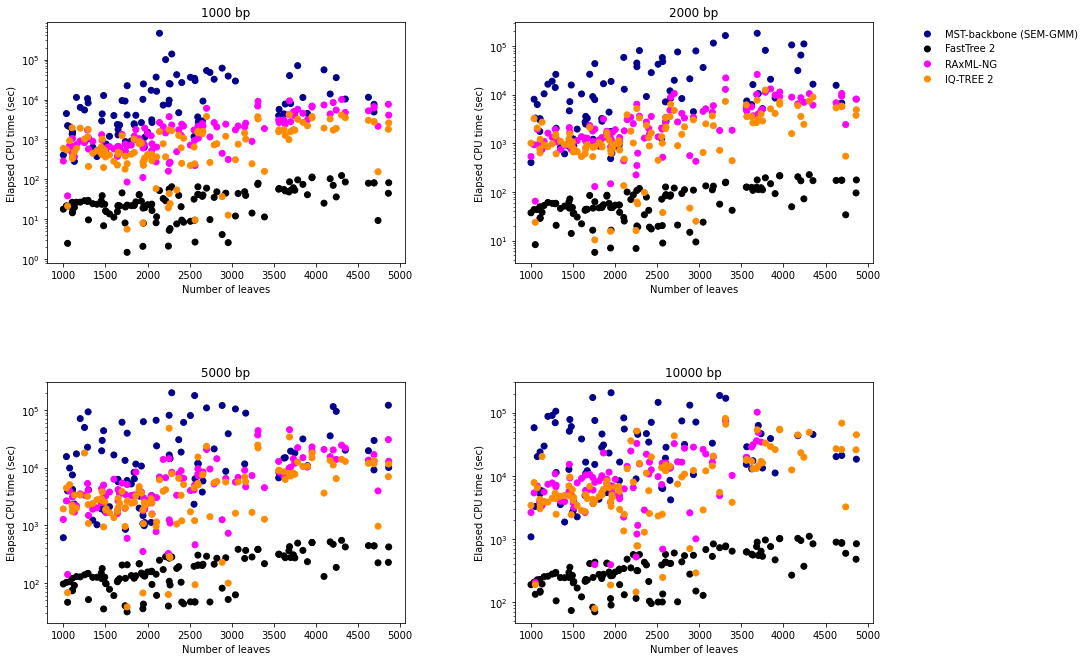

In [15]:
# Plot run times

from turtle import color
import matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.rcsetup import cycler
# cmap = ListedColormap(["darkblue","black","fuchsia","orange"])
# plt.rcParams['axes.prop_cycle'] = plt.cycler('color', cmap)
# plt.style.use('tableau-colorblind10')
import numpy as np
from math import log

# Fixing random state for reproducibility

fig, ax = plt.subplots(2,2)
i = 0
seq_len = 2000

# method_list = ['fasttree', 'mstbackbone']
# method_list = ['raxmlng','iqtree','fasttree','mstbackbone']
method_list = ['mstbackbone','fasttree','raxmlng','iqtree']
method_colors = {}
for method in method_list:
    method_colors[method] = {}
    for seq_len in seqlen_list:
        method_colors[method][seq_len] = method_colors_map[method] * len(num_leaves_seq_len_method[seq_len][method])
        # if method == 'fasttree':
        if seq_len == 1000:
            # ax_fast.subplot(2, 2, i)    
            ax[0, 0].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method,c=method_colors[method][seq_len])
            ax[0, 0].set_title(str(seq_len) + " bp")
            ax[0, 0].set_xlabel("Number of leaves")
            ax[0, 0].set_ylabel("Elapsed CPU time (sec)")
            # ax[0, 0].set_xscale("log")
            ax[0, 0].set_yscale("log")
        # elif method == 'mstbackbone':
        elif seq_len == 2000:
            # ax_mstbackbone.subplot(2, 2, i)    
            ax[0, 1].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method,c=method_colors[method][seq_len])            
            ax[0, 1].set_title(str(seq_len) + " bp")
            ax[0, 1].set_xlabel("Number of leaves")
            ax[0, 1].set_ylabel("Elapsed CPU time (sec)")
            # ax[0, 1].set_xscale("log")
            ax[0, 1].set_yscale("log")
        # elif method == 'raxmlng':
        elif seq_len == 5000:
            # ax_raxml.subplot(2, 2, i)    
            ax[1, 0].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method,c=method_colors[method][seq_len])
            ax[1, 0].set_title(str(seq_len) + " bp")
            ax[1, 0].set_xlabel("Number of leaves")
            ax[1, 0].set_ylabel("Elapsed CPU time (sec)")
            # ax[1, 0].set_xscale("log")
            ax[1, 0].set_yscale("log")
        # elif method == 'iqtree':
        elif seq_len == 10000:
            # ax_iqtree.plot(2, 2, i) 
            ax[1, 1].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method,c=method_colors[method][seq_len])
            ax[1, 1].set_title(str(seq_len) + " bp")
            ax[1, 1].set_xlabel("Number of leaves")
            ax[1, 1].set_ylabel("Elapsed CPU time (sec)")
            # ax[1, 1].set_xscale("log")
            ax[1, 1].set_yscale("log")
# ax.set_yscale("log")
fig.tight_layout(pad=0.04)
plt.legend(['MST-backbone (SEM-GMM)','FastTree 2','RAxML-NG', 'IQ-TREE 2'], bbox_to_anchor=(1.6,2.2), loc ="lower right", frameon=False)
fig.set_size_inches(13, 10)
plt.savefig(results_path+"grove_scalability.eps", dpi=100,bbox_inches='tight')
# plt.show()
# plt.show()




In [13]:
run_times_seq_len_method[10000]['mstbackbone']

[1077.0,
 20061.0,
 57585.0,
 3250.0,
 5178.0,
 23795.0,
 5863.0,
 5750.0,
 29455.0,
 87181.0,
 90044.0,
 69042.0,
 105033.0,
 11256.0,
 3491.0,
 1847.0,
 77659.0,
 50645.0,
 12600.0,
 60033.0,
 2586.0,
 3893.0,
 2799.0,
 2233.0,
 38156.0,
 12011.0,
 4869.0,
 16402.0,
 10925.0,
 30423.0,
 14804.0]

In [16]:
# Store (Precision, Recall, RF) x (Rooted, Unrooted) x (FastTree, MST-backbone, RAxML-NG, IQ-TREE) x (1000, 2000, 5000, 10000)
recall_rooted_seq_len_method = {}
recall_unrooted_seq_len_method = {}
num_leaves_seq_len_method = {}
tree_id_seq_len_method = {}
accuracy_seq_len_method = {}
for seq_len in seqlen_list:
    recall_unrooted_seq_len_method[seq_len] = {}    
    recall_rooted_seq_len_method[seq_len] = {}
    num_leaves_seq_len_method[seq_len] = {}
    accuracy_seq_len_method[seq_len] = {}
    tree_id_seq_len_method[seq_len] = {}    
    for method in method_list:
        recall_unrooted_seq_len_method[seq_len][method] = []
        recall_rooted_seq_len_method[seq_len][method] = []
        num_leaves_seq_len_method[seq_len][method] = []
        accuracy_seq_len_method[seq_len][method] = []
        tree_id_seq_len_method[seq_len][method] = []


        
results_path = projectPath + "results/"
data_path = projectPath + "data/"

accuracy_grove_file = open(results_path + "grove_accuracy_oct_10","r")
accuracy_grove_file.readline()
for res in accuracy_grove_file:
    acc = res.split(",")
    pr_unrooted, re_unrooted, rf_unrooted, pr_rooted, re_rooted, rf_rooted, method, tree_id, seq_len, num_leaves = acc
    seq_len = int(seq_len)
    num_leaves = int(num_leaves)    
    accuracy_seq_len_method[seq_len][method].append(acc)
    recall_unrooted_seq_len_method[seq_len][method].append(float(re_unrooted))
    recall_rooted_seq_len_method[seq_len][method].append(float(re_rooted))
    num_leaves_seq_len_method[seq_len][method].append(int(num_leaves))
    tree_id_seq_len_method[seq_len][method].append(tree_id)


accuracy_grove_file.close()

from metrics import ComputePrecisionRecallAndRFGivenSplits, ComputePrecisionRecallAndRFforNonTrivialClusters, ComputePrecisionRecallAndRFforRootedTrees
from fileIO import ReadTree
data_path = projectPath + "data/"

def Get_accuracy(method,exp_id):    
    pr_rooted, re_rooted, rf_rooted = -1, -1, -1
    pr_unrooted, re_unrooted, rf_unrooted = -1, -1, -1
    tree_id = exp_id.split('_numLeaves_')[0].split('treeId_')[1]
    model_tree_file_name = data_path + 'RAxMLGrove/trees/' + tree_id + '/tree_best.newick'
    RT_model = ReadRootedTree(model_tree_file_name,"newick")
    splits_model = RT_model.GetAllNonTrivialSplits()
    if method == "raxmlng":
        tree_type = "unrooted"
        estimated_tree_file_name = projectPath + 'batch_scripts/RAxMLNG_' + exp_id + '.raxml.bestTree' 
    elif method == "fasttree":
        tree_type = "unrooted"
        estimated_tree_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_newick'       
    elif method == "mstbackbone":
        tree_type = "rooted"
        estimated_tree_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.newick'
    elif method == "iqtree":
        tree_type = "rooted"
        estimated_tree_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.treefile'
    if tree_type == "rooted":
        RT_estimated = ReadRootedTree(estimated_tree_file_name, 'newick')
        pr_rooted, re_rooted, rf_rooted = ComputePrecisionRecallAndRFforRootedTrees(RT_model, RT_estimated)       
    elif tree_type == "unrooted":
        T_estimated = ReadTree(estimated_tree_file_name, 'newick')
        u_name, v_name = list(T_estimated.edgeLengths.keys())[0]
        t = T_estimated.GetEdgeLength(u_name, v_name)
        RT_estimated = T_estimated.GetRootedTree(u_name, v_name, t/2.0, t/2.0)    
    splits_estimated = RT_estimated.GetAllNonTrivialSplits()
    pr_unrooted, re_unrooted, rf_unrooted = ComputePrecisionRecallAndRFGivenSplits(splits_model, splits_estimated)
    return ([pr_unrooted, re_unrooted, rf_unrooted, pr_rooted, re_rooted, rf_rooted])

method_list = ['fasttree','iqtree','mstbackbone','raxmlng']
seqlen_list = [1000,2000,5000,10000]
# accuracy_seq_len_method = {}
# num_leaves_seq_len_method = {}
# tree_id_seq_len_method = {}
# for seq_len in seqlen_list:
#     accuracy_seq_len_method[seq_len] = {}
#     num_leaves_seq_len_method[seq_len] = {}
#     tree_id_seq_len_method[seq_len] = {}
#     for method in method_list:
#         accuracy_seq_len_method[seq_len][method] = []
#         num_leaves_seq_len_method[seq_len][method] = []
#         tree_id_seq_len_method[seq_len][method] = []        

num_leaves_list = []
accuracy_grove_file = open(results_path + "grove_accuracy_updated","w")
accuracy_grove_file.write("pr_unrooted, re_unrooted, rf_unrooted, pr_rooted, re_rooted, rf_rooted, method, tree_id, seq_len, num_leaves\n")
tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
num_trees_processed = 0
for line in tree_id_num_leaves_scalability_file:    
    tree_id = line.strip().split(',')[0].strip()
    num_leaves = int(line.strip().split(',')[1].strip())
    for seq_len in seqlen_list:
        for method in method_list:
            exp_id = "treeId_" + tree_id + "_numLeaves_" + str(num_leaves) + "_seqLen_" + str(seq_len)
            if tree_id in tree_id_seq_len_method[seq_len][method]:
                tree_ind = tree_id_seq_len_method[seq_len][method].index(tree_id)
                accuracy = accuracy_seq_len_method[seq_len][method][tree_ind]
                for acc in accuracy:
                    accuracy_grove_file.write(str(acc) + ",")
                accuracy_grove_file.write(method + "," + str(tree_id) + "," + str(seq_len) + "," + str(num_leaves) + "\n")
            else:                
                if Check_results_file_names(method,exp_id):
                    accuracy = Get_accuracy(method,exp_id)
                    accuracy_seq_len_method[seq_len][method].append(accuracy)
                    for acc in accuracy:
                        accuracy_grove_file.write(str(acc) + ",")
                    num_leaves_seq_len_method[seq_len][method].append(num_leaves)
                    tree_id_seq_len_method[seq_len][method].append(tree_id)
                    accuracy_grove_file.write(method + "," + str(tree_id) + "," + str(seq_len) + "," + str(num_leaves) + "\n")
            print (tree_id)
    num_trees_processed += 1    
    print("Finished computing accuracy for ", num_trees_processed, " trees")





accuracy_grove_file.close()
tree_id_num_leaves_scalability_file.close()

12258
12258
12258
12258
12258
12258
12258
12258
12258
12258
12258
12258
12258
12258
12258
12258
Finished computing accuracy for  1  trees
11413
11413
11413
11413
11413
11413
11413
11413
11413
11413
11413
11413
11413
11413
11413
11413
Finished computing accuracy for  2  trees
13668
13668
13668
13668
13668
13668
13668
13668
13668
13668
13668
13668
13668
13668
13668
13668
Finished computing accuracy for  3  trees
19588
19588
19588
19588
19588
19588
19588
19588
19588
19588
19588
19588
19588
19588
19588
19588
Finished computing accuracy for  4  trees
12132
12132
12132
12132
12132
12132
12132
12132
12132
12132
12132
12132
12132
12132
12132
12132
Finished computing accuracy for  5  trees
15813
15813
15813
15813
15813
15813
15813
15813
15813
15813
15813
15813
15813
15813
15813
15813
Finished computing accuracy for  6  trees
29800
29800
29800
29800
29800
29800
29800
29800
29800
29800
29800
29800
29800
29800
29800
29800
Finished computing accuracy for  7  trees
10610
10610
10610
10610
10610
1061

NameError: name 'accuracy_seq_len_method' is not defined

In [ ]:
# Write accuracy to file
results_path = projectPath + "results/"
data_path = projectPath + "data/"
accuracy_grove_file = open(results_path + "grove_accuracy","w")
accuracy_grove_file.write("pr_unrooted, re_unrooted, rf_unrooted, pr_rooted, re_rooted, rf_rooted, method, tree_id, seq_len, num_leaves\n")
method_list = ['fasttree','iqtree','mstbackbone','raxmlng']
seqlen_list = [1000,2000,5000,10000]
for seq_len in seqlen_list:
    for method in method_list:
        num_results = len(accuracy_seq_len_method[seq_len][method])
        for i in range(num_results):
            for acc in accuracy_seq_len_method[seq_len][method][i]:
                accuracy_grove_file.write(str(acc) + ",")            
            num_leaves = num_leaves_seq_len_method[seq_len][method][i]
            tree_id = tree_id_seq_len_method[seq_len][method][i]
            accuracy_grove_file.write(method + "," + str(tree_id) + "," + str(seq_len) + ", " + str(num_leaves) + "\n")






accuracy_grove_file.close()


In [4]:
# Read accuracy from file
recall_rooted_seq_len_method = {}
recall_unrooted_seq_len_method = {}
num_leaves_seq_len_method = {}
tree_id_seq_len_method = {}
for seq_len in seqlen_list:
    recall_unrooted_seq_len_method[seq_len] = {}
    recall_rooted_seq_len_method[seq_len] = {}
    num_leaves_seq_len_method[seq_len] = {}
    tree_id_seq_len_method[seq_len] = {}
    for method in method_list:
        recall_unrooted_seq_len_method[seq_len][method] = []
        recall_rooted_seq_len_method[seq_len][method] = []
        num_leaves_seq_len_method[seq_len][method] = []
        tree_id_seq_len_method[seq_len][method] = []



        
results_path = projectPath + "results/"
data_path = projectPath + "data/"

accuracy_grove_file = open(results_path + "grove_accuracy_oct_10","r")
accuracy_grove_file.readline()
for res in accuracy_grove_file:
    pr_unrooted, re_unrooted, rf_unrooted, pr_rooted, re_rooted, rf_rooted, method, tree_id, seq_len, num_leaves = res.split(",")    
    seq_len = int(seq_len)
    num_leaves = int(num_leaves)    
    recall_unrooted_seq_len_method[seq_len][method].append(float(re_unrooted))
    recall_rooted_seq_len_method[seq_len][method].append(float(re_rooted))
    num_leaves_seq_len_method[seq_len][method].append(int(num_leaves))
    tree_id_seq_len_method[seq_len][method].append(tree_id)


accuracy_grove_file.close()


In [5]:
results_path = projectPath + "results/"
data_path = projectPath + "data/"
import pandas as pd
accuracy_grove = pd.read_csv(results_path + "grove_accuracy_oct_10")
accuracy_grove.rename(columns=lambda x: x.strip(),inplace=True)

# print(accuracy_grove.keys())
accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == 1000]
print(accuracy_seq_len[accuracy_seq_len['method'] == 'fasttree']['re_unrooted'])
print(accuracy_seq_len[accuracy_seq_len['method'] == 'fasttree']['tree_id'])
print(accuracy_seq_len[accuracy_seq_len['method'] == 'fasttree']['seq_len'])
# recall_unrooted_seq_len_method[seq_len]

0       0.596386
16      0.664799
32      0.830591
48      0.021968
64      0.666063
          ...   
1657    0.510770
1672    0.509595
1687    0.018155
1698    0.491365
1711    0.415638
Name: re_unrooted, Length: 115, dtype: float64
0       12258
16      11413
32      13668
48      19588
64      12132
        ...  
1657    24986
1672    53458
1687    14206
1698    15551
1711    21337
Name: tree_id, Length: 115, dtype: int64
0       1000
16      1000
32      1000
48      1000
64      1000
        ... 
1657    1000
1672    1000
1687    1000
1698    1000
1711    1000
Name: seq_len, Length: 115, dtype: int64


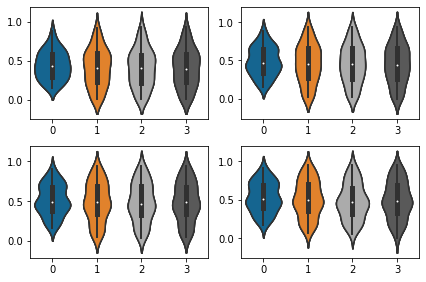

In [6]:
# Plot accuracy
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('tableau-colorblind10')
import numpy as np
from math import log

#TODO add sequence length, change colors, 

fig, ax = plt.subplots(2,2)
i = 0
seq_len = 1000
pos_method = {}
method_list = ['mstbackbone','fasttree','raxmlng','iqtree']
# pos_method['mstbackbone'] = 1 
# pos_method['fasttree'] = 2
# pos_method['raxmlng'] = 3
# pos_method['iqtree'] = 4
pos = [1,2,3,4]

recall_unrooted_list = {}
for seq_len in seqlen_list: 
    accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == seq_len]           
    recall_unrooted_list[seq_len] = []
    for method in method_list:
        recall_unrooted_list[seq_len].append(accuracy_seq_len[accuracy_seq_len['method'] == method]['re_unrooted'])

for seq_len in seqlen_list: 
    accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == seq_len]           
    for method in method_list:
        if seq_len == 1000:
            # ax[0, 0].violinplot(recall_unrooted_list[seq_len], pos)
            sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[0,0])
            # ax[0, 0].set_title(seq_len)
            # ax[0, 0].set_yscale("log")
        elif seq_len == 2000:
            sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[0,1])
            # ax[0, 1].violinplot(recall_unrooted_list[seq_len], pos)
            # ax[0, 1].set_title(seq_len)
            # ax[0, 1].set_yscale("log")
        elif seq_len == 5000:
            sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[1,0])
            # ax[1, 0].violinplot(recall_unrooted_list[seq_len], pos)
            # ax[1, 0].set_xticks([1,2,3,4],labels=['MST-backbone', 'FastTree', 'RAxML-NG', 'IQ-Tree'])
            # ax[1, 0].set_yscale("log")
        elif seq_len == 10000:
            sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[1,1])
            # ax[1, 1].violinplot(recall_unrooted_list[seq_len], pos)
            # ax[1, 1].set_title(seq_len)
            # ax[1, 1].set_yscale("log")
fig.tight_layout(pad=1.0)
# labels = ['A', 'B', 'C', 'D']
# plt.legend(method_list, loc ="upper right")
# plt.xlabel(method_list)
plt.show()

{1000: {'mstbackbone': 65, 'fasttree': 16, 'raxmlng': 6, 'iqtree': 8}, 2000: {'mstbackbone': 50, 'fasttree': 20, 'raxmlng': 9, 'iqtree': 12}, 5000: {'mstbackbone': 45, 'fasttree': 31, 'raxmlng': 8, 'iqtree': 8}, 10000: {'mstbackbone': 31, 'fasttree': 25, 'raxmlng': 9, 'iqtree': 10}}


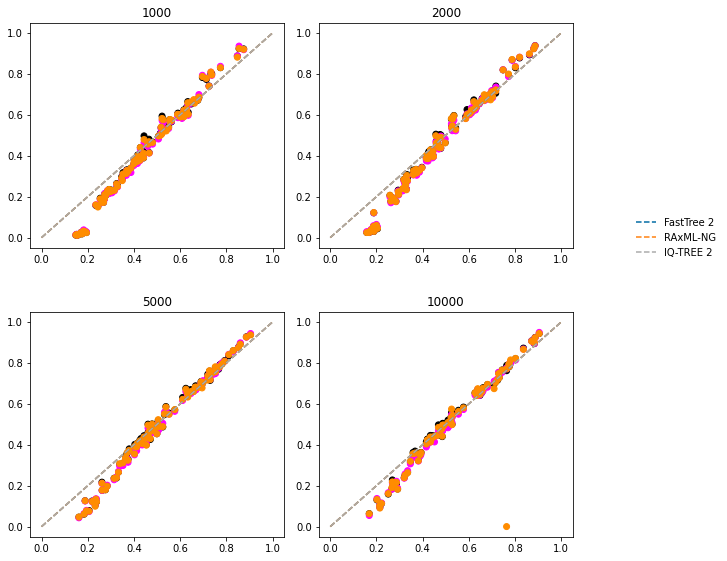

In [16]:
# Recall ranking

from matplotlib.lines import lineStyles
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('tableau-colorblind10')
import numpy as np
from math import log

results_path = projectPath + "results/"
data_path = projectPath + "data/"
import pandas as pd
accuracy_grove = pd.read_csv(results_path + "grove_accuracy_oct_10")
accuracy_grove.rename(columns=lambda x: x.strip(),inplace=True)

# print(accuracy_grove.keys())
# accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == 1000]
# accuracy_seq_len_mstbackbone = accuracy_seq_len[accuracy_seq_len['method'] == 'mstbackbone']
# accuracy_seq_len_mstbackbone['tree_id'][accuracy_seq_len_mstbackbone.index(tree_id)]
# print(accuracy_seq_len[accuracy_seq_len['method'] == 'fasttree']['re_unrooted'])
# print(accuracy_seq_len[accuracy_seq_len['method'] == 'fasttree']['tree_id'])
# print(accuracy_seq_len[accuracy_seq_len['method'] == 'fasttree']['seq_len'])
from collections import Counter
recall_rank_all = {}
recall_common_seq_len_method = {}
# recall_wrt_mstbackbone = {}
for seq_len in seqlen_list:
    recall_common_seq_len_method[seq_len] = {}
    # recall_wrt_mstbackbone[seq_len] = {}
    for method in method_list:
        recall_common_seq_len_method[seq_len][method] = []
        # recall_wrt_mstbackbone[seq_len][method] = []    
for seq_len in seqlen_list:
    recall_rank_all[seq_len] = []
    tree_id_common = set([])
    accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == seq_len]   
    accuracy_seq_len_mstbackbone = accuracy_seq_len[accuracy_seq_len['method'] == 'mstbackbone']
    tree_id_common = set(accuracy_seq_len_mstbackbone['tree_id'])
    for method in method_list[1:]:
        accuracy_seq_len_method = accuracy_seq_len[accuracy_seq_len['method'] == method]
        tree_id_common = tree_id_common.intersection(set(accuracy_seq_len_method['tree_id']))
    tree_id_common_list = [int(x) for x in list(tree_id_common)]
    # print(len(tree_id_common_list)," results in common for seq len ", seq_len)    
    for tree_id in tree_id_common_list:
        recall_method = []
        for method in method_list:
            accuracy_seq_len_method = accuracy_seq_len[accuracy_seq_len['method'] == method]            
            tree_id_seq_len_method = [int(x) for x in list(accuracy_seq_len_method['tree_id'])]
            res_ind = tree_id_seq_len_method.index(tree_id)
            recall_unrooted_seq_len_method = list(accuracy_seq_len_method['re_unrooted'])  
            recall = float(recall_unrooted_seq_len_method[res_ind])
            # recall_common_seq_len_method[seq_len][method].append()            
            # assert(accuracy_seq_len_mstbackbone['tree_id'][res_ind] == tree_id)
            recall_common_seq_len_method[seq_len][method].append(recall)
            recall_method.append((recall,method))
        recall_method.sort(key = lambda x: x[0],reverse=True)
        method_sorted = [x[1] for x in recall_method]
        # recall_sorted = [x[0] for x in recall_method]
        # print(recall_sorted)
        # print("*********************************")
        for method in method_list:
            rank = method_sorted.index(method) + 1
            recall_rank_all[seq_len].append(str(rank) + "_" + method)
#     for method in method_list:
#         accuracy_seq_len_method = accuracy_seq_len[accuracy_seq_len['method'] == method]        
#         for tree_id in tree_id_common_list:
#             accuracy_seq_len_method.index(accuracy_seq_len_method   )

#     recall_unrooted = []
#     recall_unrooted.append()
#     recall_unrooted_seq_len_mstbackbone_common = []
#     recall_unrooted_seq_len_method_common = []
#     for tree_id in tree_id_common_list:
#         recall_unrooted_seq_len_mstbackbone =  accuracy_seq_len_mstbackbone['tree_id']
#     break
# recall_unrooted_list = {}
# for seq_len in seqlen_list: 
#     accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == seq_len]           
#     recall_unrooted_list[seq_len] = []
#     for method in method_list:
#         recall_unrooted_list[seq_len].append(accuracy_seq_len[accuracy_seq_len['method'] == method]['re_unrooted'])
first_rank_count_seq_len_method = {}
for seq_len in seqlen_list:
    first_rank_count_seq_len_method[seq_len] = {}
    total_first_rank_res = 0
    total_second_rank_res = 0
    for method in method_list:
        first_rank_method = str(1)+"_"+method
        second_rank_method = str(2)+"_"+method
        # first_rank_method_count = recall_rank_all[seq_len].count(first_rank_method)
        first_rank_count_seq_len_method[seq_len][method] = recall_rank_all[seq_len].count(first_rank_method)
        total_first_rank_res += recall_rank_all[seq_len].count(first_rank_method)
        total_second_rank_res += recall_rank_all[seq_len].count(second_rank_method)
    assert(total_first_rank_res == total_second_rank_res)
    
    # recall_rank_all[seq_len]
    # print("Rankings for sequence length: ",seq_len)
    # print(Counter(i for i in recall_rank_all[seq_len]))
print(first_rank_count_seq_len_method)    

fig, ax = plt.subplots(2,2)

# fig = plt.figure(figsize = (10, 5))
method_colors_method_seq_len = []
# method_colors[method] = {}
# for seq_len in seqlen_list:  

plot_bar = False
plot_scatter = True

# creating the bar plot
for seq_len in seqlen_list: 
    # accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == seq_len]               
    for method in method_list[1:]:        
        method_colors_method_seq_len = method_colors_map[method] * len(recall_common_seq_len_method[seq_len][method])
        if seq_len == 1000:
            ax[0, 0].set_title(seq_len)
            if plot_scatter:            
                ax[0, 0].plot([0,1],[0,1],linestyle = "dashed")
                ax[0, 0].scatter(recall_common_seq_len_method[seq_len]["mstbackbone"],recall_common_seq_len_method[seq_len][method],c=method_colors_method_seq_len)
            # ax[0, 0].bar(first_rank_count_seq_len_method[seq_len])
            # ax[0, 0].bar(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])            

            # sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[0,0])
            
            # ax[0, 0].set_xticklabels([" "," ", " ", " "],rotation=0)
            # ax[0, 0].set_xticklabels(["MST-backbone(SEM-GM)","FastTree 2", "RAxML-NG", "IQ-TREE 2"],rotation=30)
            # ax[0, 0].xticks(rotation=30)
            # ax[0, 0].set_yscale("log")
        elif seq_len == 2000:
            ax[0, 1].set_title(seq_len)
            if plot_scatter:
            # sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[0,1])
                ax[0, 1].plot([0,1],[0,1],linestyle = "dashed")
                ax[0, 1].scatter(recall_common_seq_len_method[seq_len]["mstbackbone"],recall_common_seq_len_method[seq_len][method],c=method_colors_method_seq_len)
            # ax[0, 1].bar(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])
            # ax[0, 1].violinplot(recall_unrooted_list[seq_len], pos)            
            # ax[0, 1].set_xticklabels([" "," ", " ", " "],rotation=0)
            # ax[0, 1].set_xticklabels(["MST-backbone(SEM-GM)","FastTree 2", "RAxML-NG", "IQ-TREE 2"],rotation=30)
            # ax[0, 1].xticks(rotation=30)
            # ax[0, 1].set_yscale("log")
        elif seq_len == 5000:
            ax[1, 0].set_title(seq_len)
            if plot_scatter:
            # sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[1,0])
            # ax[1, 0].bar(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])
                ax[1, 0].plot([0,1],[0,1],linestyle = "dashed")
                ax[1, 0].scatter(recall_common_seq_len_method[seq_len]["mstbackbone"],recall_common_seq_len_method[seq_len][method],c=method_colors_method_seq_len)
            # ax[1, 0].scatter(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])
            # ax[1, 0].violinplot(recall_unrooted_list[seq_len], pos)
            # ax[1, 0].set_xticks([1,2,3,4],labels=['MST-backbone', 'FastTree', 'RAxML-NG', 'IQ-Tree'])            
            # ax[1, 0].set_xticklabels(["MST-backbone(SEM-GM)","FastTree 2", "RAxML-NG", "IQ-TREE 2"],rotation=30)
            # ax[1, 0].xticks(rotation=30)
            # ax[1, 0].set_yscale("log")
        elif seq_len == 10000:
            ax[1, 1].set_title(seq_len)
            if plot_scatter:
                ax[1, 1].plot([0,1],[0,1],linestyle = "dashed")
                ax[1, 1].scatter(recall_common_seq_len_method[seq_len]["mstbackbone"],recall_common_seq_len_method[seq_len][method],c=method_colors_method_seq_len)
            # ax[1, 1].bar(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])            
            # ax[1, 1].set_xticklabels(["MST-backbone(SEM-GM)","FastTree 2", "RAxML-NG", "IQ-TREE 2"],rotation=30)
            # ax[1, 1].xticks(rotation=30)
            # sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[1,1])
        
fig.tight_layout(pad=-0.1)
# plt.legend(['MST-backbone (SEM-GMM)','FastTree 2','RAxML-NG', 'IQ-TREE 2'], bbox_to_anchor=(1.6,1.2), loc ="lower right", frameon=False)
plt.legend(['FastTree 2','RAxML-NG', 'IQ-TREE 2'], bbox_to_anchor=(1.6,1.2), loc ="lower right", frameon=False)
fig.set_size_inches(8, 8)
# plt.savefig(results_path+"grove_recall_split_barplot.eps", dpi=100,bbox_inches='tight')
# plt.savefig(results_path+"grove_recall_wrt_mstbackbone.eps", dpi=100,bbox_inches='tight')
plt.show()


In [20]:
recall_common_seq_len_method[10000]["iqtree"].index(min(recall_common_seq_len_method[10000]["iqtree"]))
tree_id_common_list[51]

15712